In [1]:
import pandas as pd
import glob
import numpy as np
import scipy.sparse as ss
from collections import Counter
import matplotlib.pyplot as plt
import time
#import pyranges as pr
#import findspark
#findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,collect_list, concat, lit, when, monotonically_increasing_id, concat_ws, broadcast
import pyspark.sql.functions as F
# load in all files at the top, assert all files are correct length
# make their name the same as the input arg, minuus 'input'
spark = SparkSession.builder.master("local").appName("parquet").getOrCreate()

22/08/01 17:27:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
gene_lengths = spark.read.parquet('/sbgenomics/project-files/gene_regions_refseq.parquet')
gene_lengths = gene_lengths.withColumn('txDiff',col('txEnd') - col('txStart'))
all_gene_names = gene_lengths.select(col('name2').alias('symbol')).drop_duplicates(['symbol'])
all_gene_names_df = all_gene_names.toPandas()


In [26]:
gene_lengths.drop('#bin','name','exonStarts','exonEnds','cdsStartStat','cdsEndStat','exonFrames','score')\
            .where(col('name2') == 'KDM8').show()

+-----+------+--------+--------+--------+--------+---------+-----+-------+
|chrom|strand| txStart|   txEnd|cdsStart|  cdsEnd|exonCount|name2| txDiff|
+-----+------+--------+--------+--------+--------+---------+-----+-------+
|chr16|     +|27203485|27222305|27210123|27220730|        7| KDM8|18820.0|
|chr16|     +|27203503|27222305|27213737|27220730|        9| KDM8|18802.0|
|chr16|     +|27203518|27222305|27213737|27220730|        9| KDM8|18787.0|
|chr16|     +|27203518|27222305|27213737|27220730|        9| KDM8|18787.0|
|chr16|     +|27203525|27221768|27210123|27220730|        8| KDM8|18243.0|
|chr16|     +|27203974|27221768|27204092|27220730|        8| KDM8|17794.0|
|chr16|     +|27210092|27222305|27222305|27222305|        7| KDM8|12213.0|
|chr16|     +|27210182|27222305|27214966|27220730|        6| KDM8|12123.0|
+-----+------+--------+--------+--------+--------+---------+-----+-------+



In [3]:
kutd_annotation_tables = glob.glob('/sbgenomics/project-files/KUTD_GF_*_gene*')

In [4]:
annotation_tables = glob.glob('/sbgenomics/project-files/gene_Burden_Table_CHD_BS_*')
len(annotation_tables)

711

In [6]:
file_ids = [f.split('/')[-1] for f in annotation_tables]

pd.DataFrame(file_ids).to_csv('CHD_annotation_table_filenames.csv',index=False)

In [12]:
file_ids = pd.read_csv('CHD_annotation_table_filenames.csv').values
file_ids = [i[0] for i in file_ids]

In [14]:
mv CHD_annotation_table_filenames.csv /sbgenomics/output-files/

In [5]:
file = annotation_tables[0]
file_id = file.split('/')[-1].split('.')[0].replace('gene_Burden_Table_CHD_','')
file_id

'BS_0302Y3N5'

In [11]:
%%time

gene_score_row_list = []

for n,file in enumerate(annotation_tables):
    df = spark.read.parquet(file)
    
    if file.startswith('KUTD_'): 
        file_id = file.split('/')[-1].replace('KUTD_','').replace('_geneBurdenTable.parquet','')
    elif file.startswith('gene_burden_Table_CHD_'):
        file_id = file.split('/')[-1].split('.')[0].replace('gene_Burden_Table_CHD_','')

    print(n,file_id)
    
    # drop duplicate genes. we have multiple variants in the same gene here, but 
    # for now all we want is the overall CADD score for the gene.
    patient_genes = df.select('symbol','normed_CADD_score').drop_duplicates(['symbol'])
    joined = all_gene_names.join(patient_genes,'symbol','left')
    gene_score_col = joined.na.fill(value=0,subset=["normed_CADD_score"]).sort('symbol')\
                                    .select(col('normed_CADD_score').alias(file_id))
        
    gene_score_row_list.append(gene_score_col.toPandas().T.values[0])
    '''
    if n == 0:
        matrix = gene_score_row  #spark.createDataFrame()
    else: 
        matrix = matrix.union(gene_score_row)
    if n==3:
        break'''
    
#df.drop('cadd_score_gene_agg','end','cadd_score','AdditiveGenotype').show(2)

0 BS_0302Y3N5
CPU times: user 160 µs, sys: 2.99 ms, total: 3.15 ms
Wall time: 575 ms


In [54]:
pandas_df = pd.DataFrame(gene_score_row_list,columns=[i[0] for i in list(all_gene_names_df.values)])
pandas_df.to_csv('pandas_matrix.csv',index=False)

In [6]:
m = pd.read_csv('pandas_matrix.csv')

In [7]:
m.index = [file.split('/')[-1].replace('KUTD_','').replace('_geneBurdenTable.parquet','') for 
           file in kutd_annotation_tables]

In [8]:
mr = m.loc[:, (m.sum(axis=0) != 0)]

In [11]:
mr.shape

(44, 20329)

In [12]:
input_patient_variants = annotation_tables[0]
file_id = input_patient_variants.split('/')[-1].replace('gene_Burden_Table_CHD_','')
file_id

'BS_0302Y3N5.parquet'

In [4]:
df = spark.read.parquet(annotation_tables[0])

patient_genes = df.select('symbol','normed_CADD_score').drop_duplicates(['symbol'])
joined = all_gene_names.join(patient_genes,'symbol','left')
gene_score_col = joined.na.fill(value=0,subset=["normed_CADD_score"]).sort('symbol')\
                                .select(col('normed_CADD_score').alias(file_id))


NameError: name 'file_id' is not defined

{'whiskers': [<matplotlib.lines.Line2D at 0x7f851cf042b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f851cf04850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f851c99d730>],
 'medians': [<matplotlib.lines.Line2D at 0x7f852408a280>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f852408a640>],
 'means': []}

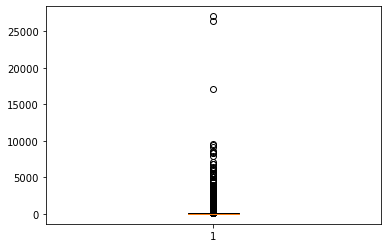

In [33]:
plt.boxplot(gene_sums)

27054.822999999997 0.002


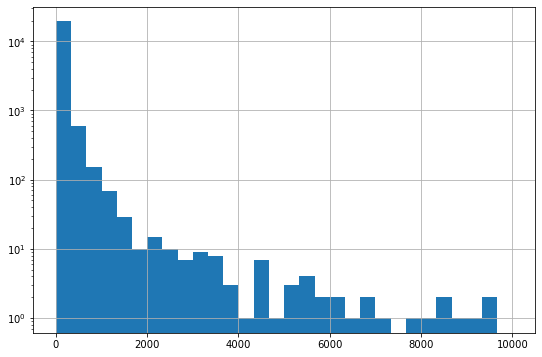

In [11]:
gene_sums = mr.sum().values
print(max(gene_sums),min(gene_sums))
plt.figure(figsize=(9,6))
plt.hist(gene_sums,bins=30,range=[0,10000])
plt.yscale('log')
plt.grid()
plt.savefig('KUTD_CADD_gene_score_dist.png')
plt.show()    

In [12]:
mv KUTD_CADD_gene_score_dist.png /sbgenomics/output-files/

In [18]:
sum(gene_sums > 500)

527

In [30]:
(mr.sum() > 500).values

False

In [69]:
mr.loc[:,(mr.sum() > 180)].shape

(44, 2085)

In [70]:
100*(2085/mr.shape[1])

10.256284126125239

### Are any of the highest genes VERY common or VERY short?

In [49]:
sum(s >100)

3732

In [44]:
s['IFI30']

71.241

In [53]:
s = mr.sum()

percentage = .25
INDEX = int(len(mr.columns)*percentage)

mr[s.sort_values(ascending=False).index[:INDEX]].head(5)

,LOC105372220,KDM8,MIR10A,LINC02301,LINC01504,LOC105374862,LOC101929759,NIBAN1,ADAM22,ZNF410,...,SCARNA9,LOC105369955,DRAXIN,TPM4,LOC105375938,LOC101928419,SULT1C3,NINJ1,GPR34,IFI30
GF_0ZR9EDHK,519.467,336.986,252.361,336.255,218.813,305.000,219.071,297.930,184.864,300.511,...,1.336,1.747,1.415,2.334,1.685,0.0,2.097,1.732,2.366,0.930
GF_1K2GTEAM,519.970,971.233,384.917,166.693,362.159,128.593,248.461,297.930,231.545,313.763,...,1.670,1.709,1.678,0.000,0.253,0.0,2.115,1.213,1.845,0.574
GF_3R71VD9D,630.793,971.233,434.931,130.613,166.458,255.231,183.858,41.123,157.291,70.076,...,1.694,1.622,1.678,0.000,0.450,0.0,1.026,1.523,2.248,0.444
GF_451FYZ8Q,670.607,660.274,340.306,129.015,196.000,130.242,239.404,297.930,170.455,120.794,...,1.337,1.751,0.718,2.334,0.253,0.0,2.115,2.696,2.338,0.870
GF_594ECSE4,755.230,660.274,807.097,131.467,346.710,90.582,152.929,297.930,188.064,140.618,...,0.955,1.632,1.945,4.579,1.270,0.0,1.089,1.832,2.448,2.600


# Build CHD gene score matrix from files

In [13]:
chd_columns = glob.glob('/sbgenomics/project-files/column_*_CHD_gene_score_matrix.csv')
len(chd_columns)

711

In [14]:
%%time
for n,file in enumerate(chd_columns):
    
    df = pd.read_csv(file)
    #print(len(df))
    if n==0:
        full_df = df
    else:
        full_df[df.columns[0]] = df
    #if n>50: break

CPU times: user 3.58 s, sys: 496 ms, total: 4.07 s
Wall time: 1min 32s


In [15]:
assert full_df.isna().sum().sum() == 0

In [97]:
np.sort(gene_lengths.dropDuplicates(['name2']).select('name2').toPandas())

array([['ALDH4A1'],
       ['CACNA1E'],
       ['CFAP57'],
       ...,
       ['LOC112268327'],
       ['LOC112268341'],
       ['LOC107987381']], dtype=object)

In [18]:
full_df = full_df.T

In [19]:
full_df.columns = [i[0] for i in all_gene_names_df.values]

In [27]:
chd_matrix  = full_df.loc[:, (full_df.sum(axis=0) != 0)]

In [35]:
chd_matrix.to_csv('chd_cadd_matrix.csv',index=False)

In [38]:
cp pandas_matrix.csv /sbgenomics/output-files/

469053.4570000001 0.0


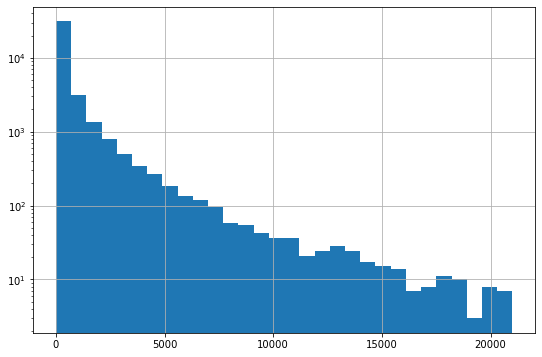

In [29]:
gene_sums = full_df.sum().values
print(max(gene_sums),min(gene_sums))
plt.figure(figsize=(9,6))
plt.hist(gene_sums,bins=30,range=[0,21000])
plt.yscale('log')
plt.grid()
plt.savefig('CHD_CADD_gene_score_dist.png')
plt.show()    

In [26]:
mv CHD_CADD_gene_score_dist.png /sbgenomics/output-files/

In [33]:
s = chd_matrix.sum()

#percentage = .25
#INDEX = int(len(mr.columns)*percentage)

chd_matrix[s.sort_values(ascending=False).index[:2]].head()

,KDM8,LOC105372220
BS_0302Y3N5,660.274,671.822
BS_03BQSV43,0.000,519.378
BS_04R6HY6V,971.233,627.726
BS_08CXN5PS,660.274,741.044
BS_0G4PAK2X,0.000,561.756
...,...,...
BS_ZWFRN4MA,0.000,580.244
BS_ZX99PGHS,647.945,445.585
BS_ZXMZDGG6,971.233,625.430
BS_ZYG3D3D7,0.000,729.170


In [86]:
42000/711    # mean gene score = ~59

59.07172995780591

In [88]:
sum(chd_matrix.sum() >44000)

174

In [109]:
s = chd_matrix.sum()

percentage = .25
INDEX = int(len(chd_matrix.columns)*percentage)

chd_matrix[s.sort_values(ascending=False).index[:INDEX]].head(5)

,KDM8,LOC105372220,MIR10A,LINC02301,LOC105374862,LINC01504,LOC101929759,NIBAN1,CACNG8,ZNF410,...,TMEM74B,LOC105374139,LINC01013,MROH3P,C17orf97,SMCHD1,DAOA,DPRX,LINC01445,LOC105375669
BS_0302Y3N5,660.274,671.822,436.111,250.796,262.934,161.196,246.447,297.930,185.228,206.008,...,1.321,1.308,2.169,1.567,0.264,0.0,0.000,1.700,1.458,1.586
BS_03BQSV43,0.000,519.378,243.597,130.131,120.758,165.308,286.624,297.930,265.007,253.534,...,1.679,1.303,0.351,0.963,1.255,0.0,1.745,1.700,1.251,0.569
BS_04R6HY6V,971.233,627.726,324.806,222.759,349.956,188.215,251.348,39.956,263.485,214.588,...,1.052,1.308,2.823,1.879,1.591,0.0,1.745,0.738,1.501,1.121
BS_08CXN5PS,660.274,741.044,334.153,70.504,95.780,257.495,286.624,297.930,59.051,266.786,...,0.281,1.308,2.770,0.802,2.058,0.0,1.745,0.004,1.370,1.121
BS_0G4PAK2X,0.000,561.756,445.528,242.657,269.154,57.897,107.461,297.930,263.529,179.046,...,1.710,1.312,1.929,0.802,2.749,0.0,1.745,1.875,0.872,2.908
